# Survey of Policy Optimization Gradient Methods in Reinforcement Learning

In this notebook, we will explore a straightforward and elegant way to solve the reinforcement learning problem. This method allows an agent to explore actions and reinforce those that lead to good outcomes (high rewards), so the agent performs them more frequently. Reinforcement learning (RL) is crucial because, like humans, agents learn from experience by trying and exploring different actions.

## Policy and actions

An agent typically has a policy that dictates what actions it should take in particular situations. For example, if an agent is driving a car and sees a person crossing the road, it should brake. One way to learn a policy is to fit a function that, given a state representation of the world, outputs a probability distribution over possible actions (a stochastic policy).

## Learning the Policy Function

Given the representational power of neural networks, one effective approach is to fit a neural network that takes a state representation as input and learns to output probabilities for each action. The goal is to maximize the expected rewards obtained by following this policy.

### Expected Reward (Performance Measure)

The performance of the policy $J(\theta)$, where $\theta$ are the parameters of the function, can be measured by the expected reward starting from the initial state. Mathematically, this is represented as:

$$
J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^{T} r(s_t, a_t) \right]
$$

Where:
- The expectation is taken over the states and actions visisted by the policy $\pi_\theta$.
- $r(s_t, a_t)$ is the reward obtained at time step $t$ given state $s_t$ and action $ a_t $.

### Policy Gradient Theorem

To optimize $ J(\theta) $, we need to compute the gradient of the expected reward with respect to the parameters $ \theta $. From the policy gradient theorem which you can find its derivation in the resources attached, the gradient of $ J(\theta) $ is given by:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot R(\tau)\right]
$$

Where:
- $\tau$ is the trajectory of the states, actions, rewards taken by the agent until the end of the episode.


By using gradient ascent, we can update the parameters $ \theta $ to maximize $ J(\theta) $:

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
$$

This approach allows us to iteratively improve the policy based on the observed rewards as the gradient can be interpreted as the direction to take to increase logarithmic probability of actions weighted by how good they were. If the reward is positive, we should follow this direction but if its negative we should go in the opposite.

### Rewards To-Go

The expression of the gradient derived for $J(\theta)$ does not take into consideration the temporal structure of rewards. Specifically, actions are weighted by the total reward of the full trajectory, which is not ideal because actions should only be credited for the rewards that occur after they are taken. Rewards achieved before an action should not influence the update for that action, as the action did not contribute to those past rewards.

Mathematically, this issue manifests because the expectation of actions weighted by the sum of rewards strictly before this action is zero. Thus, we can rewrite our unbiased estimate of the policy gradient as follows:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot \sum_{t'=t}^{T} r(s_{t'}, a_{t'})\right]
$$



# Evaluation of Policy Gradient Methods

The form introduced before is commonly known as **Vanilla Policy Gradient** as it is the simplest form and there are many methods to make things work better. But first we will evaluate this method by training an agent to play Tic Tac Toe  

In [1]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Function to return the status of the game
def check_status_game(states):
  # Check rows and columns
    for i in range(3):
        if states[i, 0] == states[i, 1] == states[i, 2] and states[i, 0] != 0:
            return int(states[i, 0]) # Player 1 or 2 won
        if states[0, i] == states[1, i] == states[2, i] and states[0, i] != 0:
            return int(states[0, i]) # Player 1 or 2 won
  # Check diagonals
    if (states[0, 0] == states[1, 1] == states[2, 2] or states[0, 2] == states[1, 1] == states[2, 0]) and states[1, 1] != 0:
        return int(states[1, 1]) # Player 1 or 2 won
    if torch.all(states != 0):
        return 3  # Draw
    return 0  # No winner yet

In [3]:
# Build the neural network that acts as the policy
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(9, 64, bias=True)  # Input is 9 dimentional (9 positions in the game)
        self.l2 = nn.Linear(64, 32, bias=True)
        self.l3 = nn.Linear(32, 9, bias=True) # 9 possible actions as output

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

    def play(self, states):
        # Flatten the input state to a 1D tensor
        states = states.flatten()

        # Get the logits from the neural network
        logits = self(states)

        # Mask filled positions with -inf so the softmax applied to it will give 0
        logits = logits.masked_fill(states != 0, float("-inf"))

        # Apply softmax to output a probability distribution over actions as demanded by our policy
        probs = F.softmax(logits, dim=0)

        return probs

In [4]:
torch.manual_seed(7)
model1 = Model()
steps = 1000
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
winning_stats = []
winning_count = 0

for step in range(steps):
    optimizer1.zero_grad()  # Zero gradients at the start of each step
    total_loss = 0
    episodes = 5

    for ep in range(episodes):
        states = torch.zeros((3, 3), dtype=torch.float32)  # Initialize game state
        episode_log_probs = []
        finished = False

        while not finished:
            # Agent's turn
            probs = model1.play(states)
            pos = torch.multinomial(probs, num_samples=1).item()  # Sample action from probability distribution
            log_prob = torch.log(probs[pos])
            episode_log_probs.append(log_prob)

            # Update the game state based on the chosen action
            new_states = states.clone()
            new_states[pos // 3, pos % 3] = 1  # Agent's move
            states = new_states

            # Check if the game has ended
            result = check_status_game(states)
            if result != 0:
                finished = True
                break

            # Random agent's turn
            valid_moves = (states == 0).flatten().nonzero().squeeze()
            random_move = valid_moves[torch.randint(len(valid_moves), (1,))].item()

            # Update the game state based on the random agent's move
            new_states = states.clone()
            new_states[random_move // 3, random_move % 3] = 2  # Random agent's move
            states = new_states

            # Check if the game has ended
            result = check_status_game(states)
            if result != 0:
                finished = True

        # Determine reward for the episode
        if result == 1:  # Agent won
            reward = 1.0
            winning_count += 1
        elif result == 2:  # Random agent won
            reward = -1.0
        else:  # Draw
            reward = 0.2

        # Accumulate loss for this episode
        if episode_log_probs:
            episode_loss = torch.stack(episode_log_probs).sum() * (-reward)
            total_loss += episode_loss / episodes  # Normalize by number of episodes

    # Backward pass and optimization after all episodes
    if total_loss != 0:
        total_loss.backward()
        optimizer1.step()

    # Record winning statistics every 5 steps
    if step % 5 == 0:
        winning_stats.append(winning_count / (episodes * 5))
        winning_count = 0

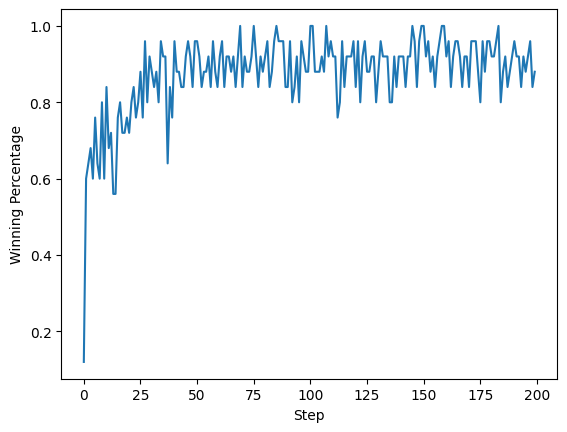

In [5]:
plt.plot(winning_stats)
plt.xlabel("Step")
plt.ylabel("Winning Percentage")
plt.show()

We have successfully trained an agent to learn how to play Tic Tac Toe using the Vanilla Policy Gradient method. This demonstrates the promise of policy gradient methods in reinforcement learning. However, to fully understand both the strengths and limitations of this approach, it is essential to evaluate it in a more complex environment.

To further assess the performance and scalability of the Vanilla Policy Gradient method, we will train an agent on the **Lunar Lander** environment from OpenAI Gym.



In [6]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 34.0 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379496 sha256=8c9d44c17393fe416853749e42059df75adbbcc80469a1f7ac45036a77a22c34
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py



Let's first see what the environment looks like.

In [7]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo


env = gym.make("LunarLander-v3", render_mode="rgb_array",continuous=False)
env = RecordVideo(env, video_folder="lunarlander-agent", name_prefix="eval",
                  episode_trigger=lambda x: True)
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()

from IPython.display import Video
Video("lunarlander-agent/eval-episode-0.mp4", embed=True)

## Policy Gradient with Baseline

The agent needs to learn how to land safely, and for that, we will use the same technique as before with a parametrized policy optimized with Vanilla Policy Gradient (VPG). However, we will add a small but very beneficial change: incorporating a baseline to reduce variance in the gradient estimates.

### Why Use a Baseline?

To compute the gradient, we used a Monte Carlo estimate of the value function where we simply rolled out the policy and averaged the reward over multiple trajectories. While on expectation, the reward obtained is equivalent to the true value function, it is still noisy. It would be preferable to remove some variance to stabilize the gradient updates. One way to reduce variance at the expense of introducing some bias is to introduce a baseline, which in most cases is an estimate of the value function. We can bootstrap this from a neural network trained to approximate the value of each state.

Mathematically, this gives us the following equation:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot (R_t - b(s_t)) \right]
$$

This also can be interpreated as an action should only be reinforced if it generates a reward better than expected:


In [8]:
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(8, 64, bias=True)  # Input is 8 dimentional (8 states)
        self.l2 = nn.Linear(64, 32, bias=True)
        self.l3 = nn.Linear(32, 4, bias=True)  # Output layer (4 possible actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return F.softmax(x, dim=1)  # Output a probability distribution over actions


class Value(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(8, 64, bias=True)
        self.l2 = nn.Linear(64, 32, bias=True)
        self.l3 = nn.Linear(32, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x  # Output the estimated value of the state


class Agent:
    def __init__(self, env, policy, value):
        self.env = env
        self.policy = policy
        self.value = value

    def play(self):
        observation, info = self.env.reset()
        episode_over = False
        while not episode_over:
            # Convert observation to tensor and get action probabilities from policy network
            observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
            probs = self.policy(observation)
            action = int(torch.multinomial(probs, num_samples=1).item())
            # Take action in the environment
            observation, reward, terminated, truncated, info = self.env.step(action)
            episode_over = terminated or truncated
        self.env.close()

    def train(self, episodes=500, discount=0.99):
        optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        saved_rewards = []
        for episode in range(episodes):
            optimizer.zero_grad()
            total_loss = 0
            runs = 8
            total_rewards = 0
            for run in range(runs):
                observation, info = self.env.reset()
                episode_over = False
                logprobs = []
                rewards = []
                while not episode_over:
                    # Convert observation to tensor and get action probabilities from policy network
                    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
                    probs = self.policy(observation)[0]
                    action = int(torch.multinomial(probs, num_samples=1).item())
                    logprob = torch.log(probs[action])
                    logprobs.append(logprob)
                    # Take action in the environment
                    observation, reward, terminated, truncated, _ = self.env.step(action)
                    rewards.append(reward)
                    episode_over = terminated or truncated

                if logprobs:
                    total_rewards += sum(rewards) / runs
                    # Compute discounted rewards
                    for i in range(len(rewards)-2, -1, -1):
                        rewards[i] += discount * rewards[i+1]
                    run_loss = -torch.stack(logprobs) * torch.tensor(rewards)
                    total_loss += run_loss.sum() / runs

            saved_rewards.append(total_rewards)
            total_loss.backward()
            optimizer.step()

        self.env.close()
        return saved_rewards

    def train_with_baseline(self, episodes=500, discount=0.99):
        optimizer_policy = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        optimizer_value = torch.optim.Adam(self.value.parameters(), lr=1e-3)
        saved_rewards = []
        for episode in range(episodes):
            optimizer_policy.zero_grad()
            optimizer_value.zero_grad()
            total_loss = 0
            value_loss = 0
            runs = 8
            total_rewards = 0
            for run in range(runs):
                observation, info = self.env.reset()
                episode_over = False
                logprobs = []
                rewards = []
                values = []
                while not episode_over:
                    # Convert observation to tensor and get action probabilities and state value from networks
                    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
                    probs = self.policy(observation)[0]
                    values.append(self.value(observation))
                    action = int(torch.multinomial(probs, num_samples=1).item())
                    logprob = torch.log(probs[action])
                    logprobs.append(logprob)
                    # Take action in the environment
                    observation, reward, terminated, truncated, _ = self.env.step(action)
                    rewards.append(reward)
                    episode_over = terminated or truncated

                if logprobs:
                    total_rewards += sum(rewards) / runs
                    # Compute discounted rewards
                    for i in range(len(rewards)-2, -1, -1):
                        rewards[i] += discount * rewards[i+1]
                    # Compute the advantage (reward - baseline)
                    advantage = torch.tensor(rewards) - torch.cat(values).squeeze()
                    advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-9)
                    run_loss = -torch.stack(logprobs) * advantage.detach()
                    total_loss += run_loss.sum() / runs
                    value_loss += F.mse_loss(torch.cat(values).squeeze(), torch.tensor(rewards, dtype=torch.float32)) / runs

            saved_rewards.append(total_rewards)
            total_loss.backward()
            value_loss.backward()
            optimizer_policy.step()
            optimizer_value.step()

        self.env.close()

        return saved_rewards

In [9]:
env = gym.make("LunarLander-v3", render_mode="rgb_array",continuous=False)
agent = Agent(env, Policy(), Value())
rewards_no_baseline = agent.train(episodes=300)

In [10]:
agent = Agent(env, Policy(), Value())
rewards_with_baseline = agent.train_with_baseline(episodes=300)

## Proximal Policy Optimization (PPO)

While the introduction of a baseline helps significantly to stabilize the updates, we still face two important issues with the stochastic gradient:

1. **Step Size Control**: We need to be careful with the step size to avoid overshooting, which can drastically deviate the policy.
2. **Sample Efficiency**: It would be preferable to be more sample efficient, allowing multiple gradient updates using the data collected from the trajectories instead of just one update.

Proximal Policy Optimization (PPO) addresses both these objectives by penalizing changes to the policy that move it far from the previous policy. PPO achieves this by clipping the ratio of the new policy probability to the old policy probability to stay close to 1, specifically between $1 - \epsilon$ and $1 + \epsilon$.


### The Clipped Surrogate Objective

The PPO objective is defined as:

$$
L^{\text{CLIP}}(\theta) = \mathbb{E}_{t} \left[ \min \left( r_t(\theta) \cdot A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \cdot A_t \right) \right]
$$

Where:
- $r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}$ is the probability ratio of the new policy to the old policy.
- $\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)$ constrains the ratio $r_t(\theta)$ to lie within $[1-\epsilon, 1+\epsilon]$.
- $A_t$ is the advantage estimate, which measures how much better an action was compared to the baseline.


Additionally, PPO can be viewed as a simplification and relaxation of the constrained optimization problem:

$$
\max_\theta \mathbb{E}_t \left[ \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)} A_t \right]
$$
subject to:
$$
\mathbb{E}_t \left[ D_{\text{KL}} \left( \pi_\theta(\cdot | s_t) \,||\, \pi_{\theta_{\text{old}}}(\cdot | s_t) \right) \right] \leq \delta
$$

Where:
- $D_{\text{KL}}$ is the Kullback-Leibler (KL) divergence, which measures how much the new policy differs from the old policy.
- $\delta$ is a hyperparameter that constrains the maximum allowed divergence.

PPO approximates this constraint by clipping $r_t(\theta)$ instead of explicitly computing and enforcing the KL divergence constraint, making it simpler and computationally efficient.

In [11]:
class Agent():
    def __init__(self, env, policy, value):
        self.env = env
        self.policy = policy
        self.value = value
        self.optimizer_policy = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        self.optimizer_value = torch.optim.Adam(self.value.parameters(), lr=1e-3)

    def play(self):
        observation, info = self.env.reset()
        episode_over = False
        while not episode_over:
            # Convert observation to tensor and predict action probabilities
            observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
            probs = self.policy(observation)

            # Sample an action from the probability distribution
            action = int(torch.multinomial(probs, num_samples=1).item())

            # Perform the action and update the state
            observation, reward, terminated, truncated, info = self.env.step(action)
            episode_over = terminated or truncated

        self.env.close()

    def get_action_value(self, observation, action=None):
        probs = self.policy(observation)
        value = self.value(observation)
        if action is None:
            action = torch.multinomial(probs, num_samples=1)
        return action, torch.log(probs[torch.arange(probs.size(0)), action.squeeze()]), value

    def collect_trajectories(self):
        observation, info = self.env.reset()
        episode_over = False
        actions, states, rewards, logprobs, values = [], [], [], [], []

        while not episode_over:
            # Get action, log-probability, and value for the current state
            observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
            action, logprob, value = self.get_action_value(observation)
            action = int(action.item())

            # Store trajectory details
            actions.append(action)
            states.append(observation)
            logprobs.append(logprob)
            values.append(value)

            # Step in the environment
            observation, reward, terminated, truncated, _ = self.env.step(action)
            rewards.append(reward)
            episode_over = terminated or truncated

        return actions, states, rewards, logprobs, values

    def compute_advantages(self, b_rewards, b_values):
        b_advantages = []
        for rewards, values in zip(b_rewards, b_values):
            # Compute advantage: reward - value
            advantages = torch.tensor(rewards) - torch.tensor(values)
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
            b_advantages.append(advantages.detach())
        return b_advantages

    def update_policy_value(self, b_actions, b_states, b_logprobs, b_advantages, b_rewards, epochs):
        for epoch in range(epochs):
            policy_loss = 0
            value_loss = 0
            for actions, states, logprobs, advantages, rewards in zip(b_actions, b_states, b_logprobs, b_advantages, b_rewards):
                # Get new log-probabilities and values for the batch
                _, new_logprobs, new_values = self.get_action_value(torch.cat(states, dim=0), torch.tensor(actions).unsqueeze(1))

                # Compute the ratio of new to old probabilities
                ratio = torch.exp(new_logprobs - torch.cat(logprobs, dim=0).detach())
                clip_epsilon = 0.2

                # Clip the ratio to control policy updates
                clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)

                # Compute the policy loss (PPO objective)
                loss = -torch.min(clipped_ratio * advantages, ratio * advantages)
                policy_loss += loss.sum() / len(b_actions)

                # Compute the value loss (Mean Squared Error)
                value_loss += F.mse_loss(torch.tensor(rewards, dtype=torch.float32).unsqueeze(1), new_values) / len(b_actions)

            # Backpropagate and update policy network
            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

            # Backpropagate and update value network
            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()

    def train(self, episodes=500, discount=0.99, clip_epsilon=0.2, batch_size=8):
        saved_rewards = []
        for episode in range(episodes):
            b_actions, b_states, b_rewards, b_logprobs, b_values = [], [], [], [], []
            total_rewards = 0

            # Collect trajectories for the current batch
            for batch in range(batch_size):
                actions, states, rewards, logprobs, values = self.collect_trajectories()
                b_actions.append(actions)
                b_states.append(states)
                b_rewards.append(rewards)
                b_logprobs.append(logprobs)
                b_values.append(values)
                total_rewards += sum(rewards) / batch_size

            saved_rewards.append(total_rewards)
            if episode % 10 == 0:
                print(f"Episode: {episode+1}, Total Rewards: {total_rewards}")

            # Compute discounted rewards
            for rewards in b_rewards:
                for i in range(len(rewards) - 2, -1, -1):
                    rewards[i] += discount * rewards[i + 1]

            # Compute advantages and update networks
            b_advantages = self.compute_advantages(b_rewards, b_values)
            self.update_policy_value(b_actions, b_states, b_logprobs, b_advantages, b_rewards, epochs=4)

        return saved_rewards


In [12]:
policy = Policy()
value = Value()
agent = Agent(env, policy, value)
rewards_ppo = agent.train(episodes=300)

Episode: 1, Total Rewards: -142.5944976336242
Episode: 11, Total Rewards: -124.91432149022921
Episode: 21, Total Rewards: -146.6560214851957
Episode: 31, Total Rewards: -155.45055226249312
Episode: 41, Total Rewards: -44.61777424968393
Episode: 51, Total Rewards: -63.196206311236296
Episode: 61, Total Rewards: 0.685618547755606
Episode: 71, Total Rewards: 0.45568794878433394
Episode: 81, Total Rewards: 7.442876686026713
Episode: 91, Total Rewards: 32.90127073331929
Episode: 101, Total Rewards: 67.71352519072899
Episode: 111, Total Rewards: 74.89283100958315
Episode: 121, Total Rewards: 100.4195488288984
Episode: 131, Total Rewards: 131.35765421987574
Episode: 141, Total Rewards: 73.16515084115204
Episode: 151, Total Rewards: 107.42126194198043
Episode: 161, Total Rewards: 49.40835645847291
Episode: 171, Total Rewards: 114.00926466371008
Episode: 181, Total Rewards: 130.20106008238704
Episode: 191, Total Rewards: 110.45894849690866
Episode: 201, Total Rewards: 111.34219358021952
Episode

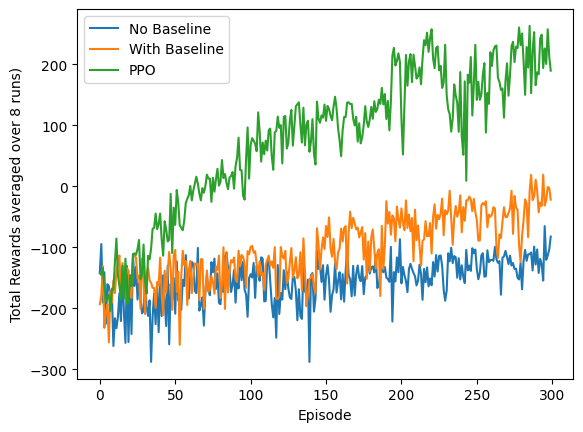

In [13]:
import matplotlib.pyplot as plt

plt.plot(rewards_no_baseline, label="No Baseline")
plt.plot(rewards_with_baseline, label="With Baseline")
plt.plot(rewards_ppo, label="PPO")
plt.xlabel("Episode")
plt.ylabel("Total Rewards averaged over 8 runs)")
plt.legend()

In [14]:
env = gym.make("LunarLander-v3", render_mode="rgb_array",continuous=False)
env = RecordVideo(env, video_folder="agent", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=1)


agent = Agent(env, policy, value)
agent.play()

env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

Episode time taken: deque([1.74373], maxlen=1)
Episode total rewards: deque([218.59763196223076], maxlen=1)
Episode lengths: deque([329], maxlen=1)


In [15]:
Video("agent/eval-episode-0.mp4", embed=True)